# Cats vs Dogs / Lesson 1 of fast.ai MOOC

This notebook is a log of what I've learned so far during the course. Mostly a reminder for myself. This notebook will demonstrate the entire process of preparing for and submitting to a kaggle competition, the dogs-vs-cats-redux-kernels-edition competition to be exact. It will use the fast.ai classes from lesson 1

In [13]:
competitionName = "dogs-vs-cats-redux-kernels-edition"


In [2]:
import os, sys
from shutil import copyfile
import numpy as np
current_dir = os.getcwd()
notebookPath = current_dir
dataPath = current_dir + "/" + "kaggle" + "/" + competitionName + "/"
resultPath = dataPath + "/results/"

# Prepare all the data using the kaggle-cli

In [8]:
%cd $notebookPath
%mkdir -p $dataPath
%cd $dataPath
# Need to have kaggle-cli installed and configured for this to work
#!kg download -c $competitionName
# Unzip the data (need to have unzip installed for this to work) suppress the output
#!unzip train.zip $dataPath >> /dev/null
#!unzip test.zip $dataPath >> /dev/null
#%rm test.zip
#%rm train.zip

%mkdir -p valid
%mkdir -p results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown



/home/ubuntu/nbs/fastAI
/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition


## Prepare the validation set
Use a random batch of the training data and use it for the validation set


In [3]:
from glob import glob
import numpy as np

In [21]:
nrValidationSamples = 2000
%cd $dataPath/train
%pwd
files = glob("*.jpg")
shuffledFiles = np.random.permutation(files)
shuffledFiles[:5]
for i in range(nrValidationSamples): os.rename(shuffledFiles[i], dataPath + '/valid/' + shuffledFiles[i])


/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/train


In [22]:
%cd $dataPath/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/valid


## Prepare the sample set
Use a few samples to quickly check the model, copy the files instead of moving

In [25]:
nrTrainSamples = 200
%cd $dataPath/train
%pwd
files = glob("*.jpg")
shuffledFiles = np.random.permutation(files)
for i in range(nrTrainSamples): copyfile(shuffledFiles[i], dataPath + '/sample/train/' + shuffledFiles[i])


/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/train


In [27]:
%cd $dataPath/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/sample/train


In [26]:
nrValidSamples = 200
%cd $dataPath/train
%pwd
files = glob("*.jpg")
shuffledFiles = np.random.permutation(files)
for i in range(nrValidSamples): copyfile(shuffledFiles[i], dataPath + '/sample/valid/' + shuffledFiles[i])


/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/train


In [28]:
%cd $dataPath/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/sample/valid


In [3]:
#Go back to main folder
%cd ../../

[Errno 2] No such file or directory: 'kaggle/dogs-vs-cats-redux-kernels-edition'
/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition
/home/ubuntu/nbs/fastAI


## Create training set

In [4]:
%cd $dataPath/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/train


## Create the test set
The test images need to be in their own folder also, we use "unknown"


In [36]:
%cd $dataPath/test
%mkdir unknown
%mv *.jpg unknown/
%cd $dataPath

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/test
mkdir: cannot create directory ‘unknown’: File exists
/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition


# Do the learning stuff..

## Import all relevant modules

In [6]:
%matplotlib inline
%cd $notebookPath
import theano
import keras
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, save_array, load_array,plot_confusion_matrix
import pandas as pd
from sklearn.metrics import confusion_matrix

/home/ubuntu/nbs/fastAI


## I use the Vgg16 kernel, as created in the fast.ai tutorial lesson 1
This is basically a wrapper around keras, using the weights from the Vgg16, the winning model from the ILSVRC-2014 competition

In [24]:
from vgg16 import Vgg16
vgg = Vgg16()

Prepare the batches, basically these are iterators. The function expects that the data is subdivided into one class
per subfolder

In [25]:
#Batch size depends on the memory available
batch_size = 32

#First the training set
batches = vgg.get_batches(dataPath +'/train', batch_size=batch_size)

#Then the validation set
val_batches = vgg.get_batches(dataPath +'/valid', batch_size=batch_size*2)

#test_batches = vgg.get_batches(test, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Finetune the model with data from the training and do the fit with the validation set the check the accuracy

In [26]:
vgg.finetune(batches)

In [12]:
vgg.fit(batches,val_batches,nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 621s - loss: 0.1286 - acc: 0.9691 - val_loss: 0.0882 - val_acc: 0.9805


In [15]:
#Save the weights
weightsFilename = 'weightsEpoch%d.h5' % 1
vgg.model.save_weights(resultPath+weightsFilename)


In [27]:
#If you don't want to the fit again..
#vgg.model.load_weights(resultPath+weightsFilename)

Try to use a smaller learning rate to finetune the fit in a separate epoch. Taking into account the accuracy of the previous
epoch

In [31]:

currentLearningRate = vgg.model.optimizer.lr.get_value()
print(currentLearningRate)
vgg.model.optimizer.lr.set_value(currentLearningRate * 0.1)
currentLearningRate = vgg.model.optimizer.lr.get_value()
print(currentLearningRate)

0.00010000000475


In [33]:
vgg.fit(batches,val_batches,nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 620s - loss: 0.0942 - acc: 0.9820 - val_loss: 0.0678 - val_acc: 0.9840


In [34]:
#Save the weights again, the accuracy improved quite a bit in this epoch, the val_loss went from 0.0882 to 0.0678
#Can probably improve by running another epoch, but not going to do this
weightsFilename = 'weightsEpoch%d.h5' % 2
vgg.model.save_weights(resultPath+weightsFilename)

# Run the test predictions

In [38]:
batches, preds = vgg.test(dataPath + "/test",batch_size=64)

Found 12500 images belonging to 1 classes.


In [41]:
filenames = batches.filenames
ids = [f[f.find("/")+1:f.find(".")] for f in batches.filenames]

In [43]:
#Save our test results arrays so we can use them again later
from utils import plots, save_array, load_array
save_array(resultPath + '/test_preds.dat', preds)
save_array(resultPath + '/filenames.dat', filenames)
save_array(resultPath + '/ids.dat', ids)


In [51]:
isDog = preds[:,1]

In [59]:
print("Number dogs found: %i and number of cats found: %i" % (len(isDog[isDog < 0.5]), len(isDog[isDog <= 0.5])))

Number dogs found: 6246 and number of cats found: 6246


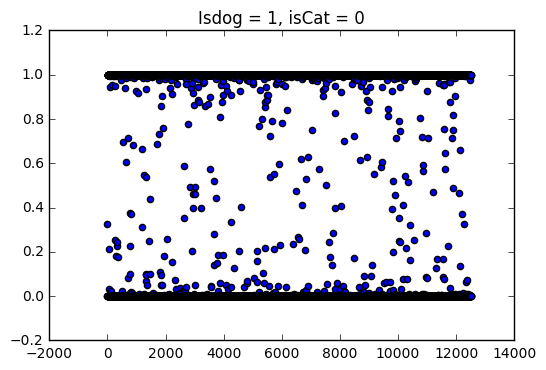

In [63]:
plt.scatter(range(0,len(isDog)),isDog)
plt.title("Isdog = 1, isCat = 0")

Most values are either 1 or 0. This is not good, since the log loss function that we are judged on on Kaggle doesn't like this. Our model is overconfident and we get punished for this when wrong. Clip the predictions to a bit less confident values

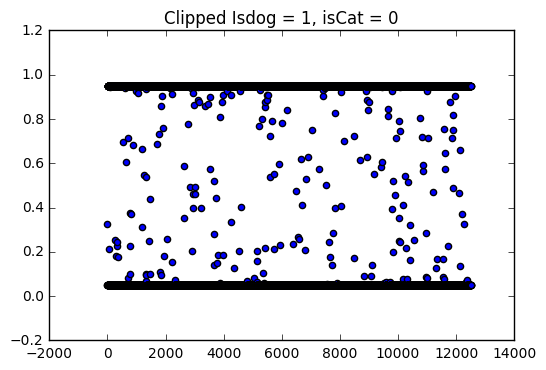

In [66]:
isDog = isDog.clip(0.05,0.95)
plt.scatter(range(0,len(isDog)),isDog)
plt.title("Clipped Isdog = 1, isCat = 0")

## Use the validation data to manually check some samples

In [92]:
validationTestbatches, validationPreds = vgg.test(dataPath + "/valid",batch_size=4)


Found 2000 images belonging to 2 classes.


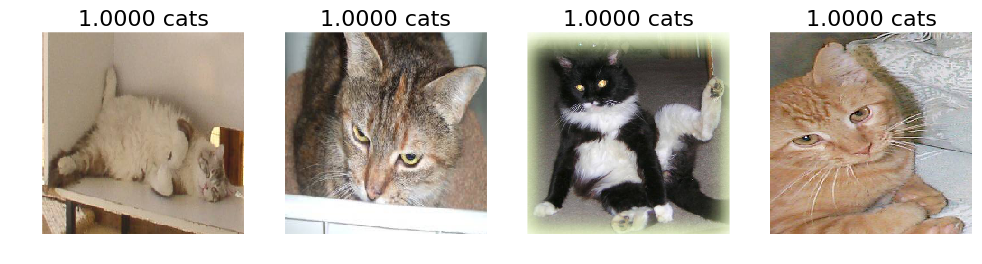

In [95]:
img=next(validationTestbatches)
res = vgg.predict(img,True)
labels = ['{:.4f}'.format(x) + " " + str(y) for x,y in zip(res[0],res[2])]
plots(img,titles=labels)

Number of true/false dogs (997 / 9), and cats (971 / 23)
[[971   9]
 [ 23 997]]


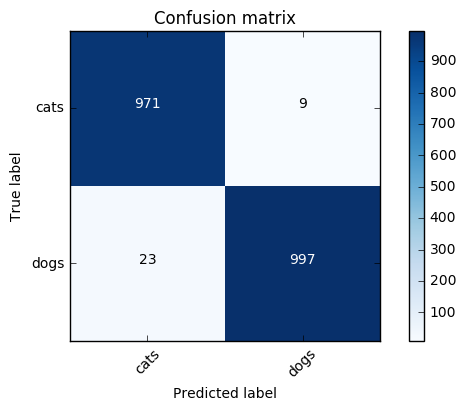

In [165]:
isDogValid = validationPreds[:,1]
trueLabels = validationTestbatches.classes
ourLabels = np.round(isDogValid)
DOG = 1
CAT = 0
trueQualifiedDogs = np.where((ourLabels == DOG) & (trueLabels == DOG))[0]
falseQualifiedDogs = np.where((ourLabels == DOG) & (trueLabels == CAT))[0]
trueQualifiedCats = np.where((ourLabels == CAT) & (trueLabels == CAT))[0]
falseQualifiedCats = np.where((ourLabels == CAT) & (trueLabels == DOG))[0]
print("Number of true/false dogs (%i / %i), and cats (%i / %i)" % (len(trueQualifiedDogs),len(falseQualifiedDogs),len(trueQualifiedCats),len(falseQualifiedCats)))


cm = confusion_matrix(trueLabels, ourLabels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [163]:
#Copied From fast.ai 
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(path,filenames,idx, titles=None):
    idx = idx[0:4]
    if(titles != None):
        titles = titles[0:4]
    plots([image.load_img(path + "/" + filenames[i]) for i in idx], titles=titles)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


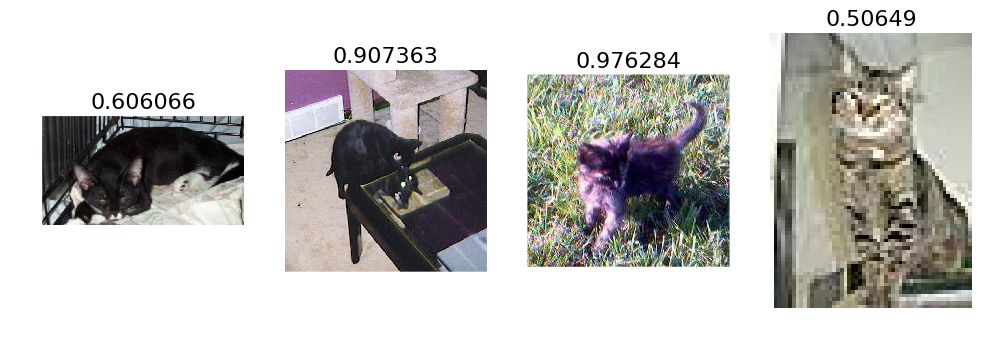

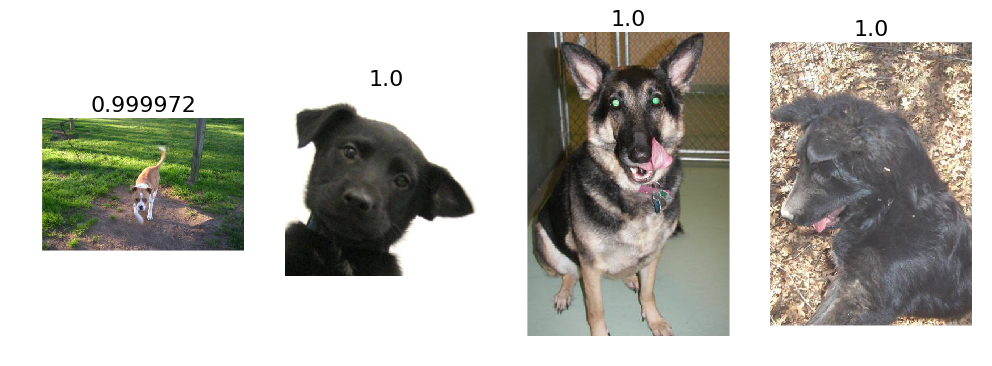

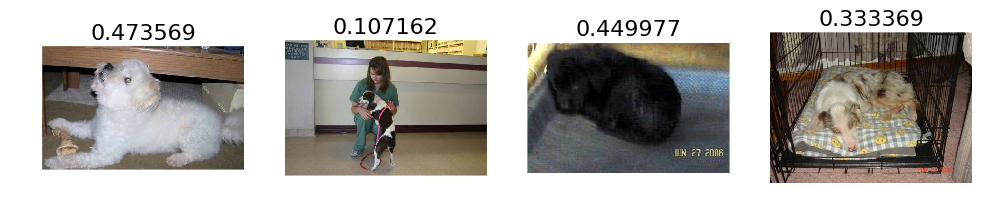

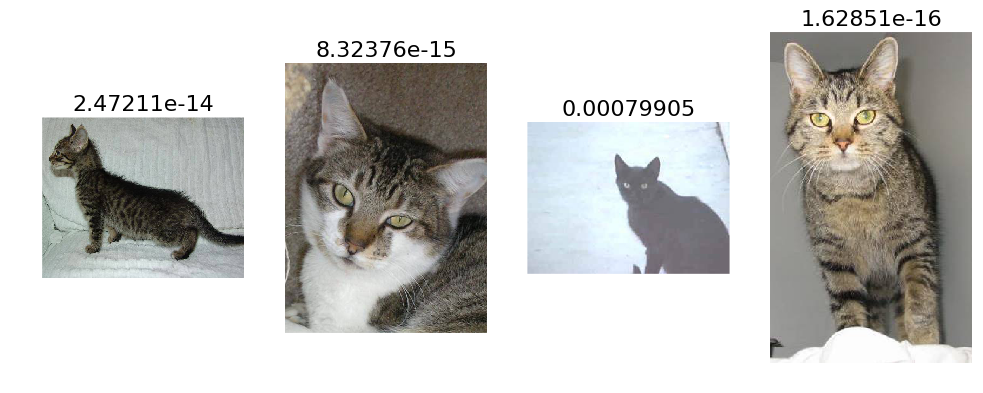

In [169]:
validFiles = validationTestbatches.filenames
plots_idx(dataPath + "/valid",validFiles,falseQualifiedDogs,isDogValid[falseQualifiedDogs])
plots_idx(dataPath + "/valid",validFiles,trueQualifiedDogs,isDogValid[trueQualifiedDogs])
plots_idx(dataPath + "/valid",validFiles,falseQualifiedCats,isDogValid[falseQualifiedCats])
plots_idx(dataPath + "/valid",validFiles,trueQualifiedCats,isDogValid[trueQualifiedCats])

# Prepare for submission to Kaggle

First get the predictions for the test dataset. The batches variable holds the iterator to the test filenames and the preds gives a label with a confidence prediction. (1 = dog, 0 = cat).

In [173]:
preds = load_array(resultPath + '/test_preds.dat')
filenames = load_array(resultPath + '/filenames.dat')
ids = load_array(resultPath + '/ids.dat')

In [268]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
isDog = preds[:,1].clip(0.05,0.95)
submission = pd.DataFrame({'id':ids, 'label': isDog})

files = pd.DataFrame({'id':ids, 'filename':filenames})

## Check the submission table and some random images 

In [273]:
submission.head(4)

,id,label
0,9292,0.050000
1,12026,0.324459
2,9688,0.050000
3,4392,0.050000


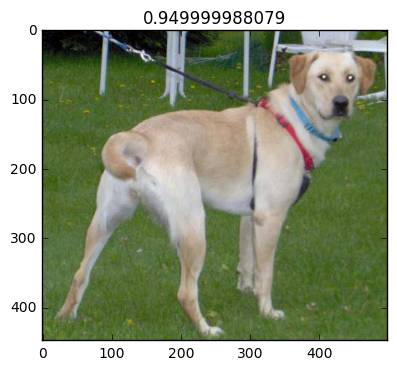

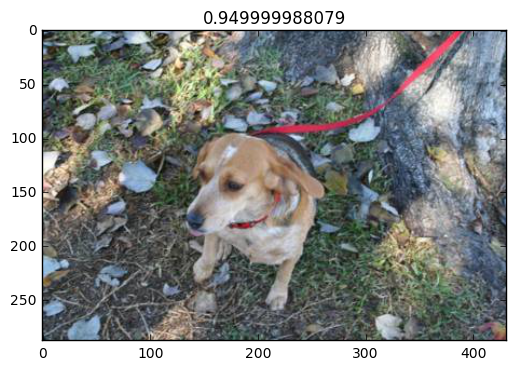

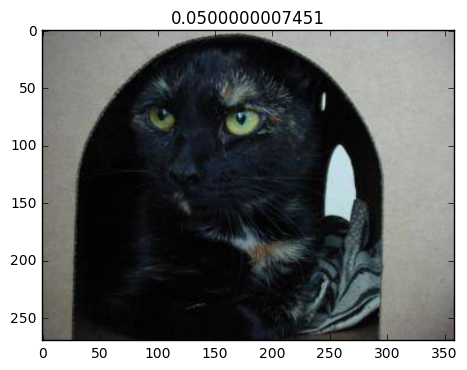

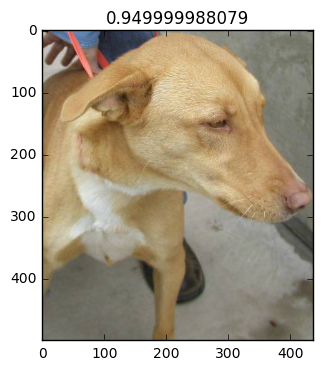

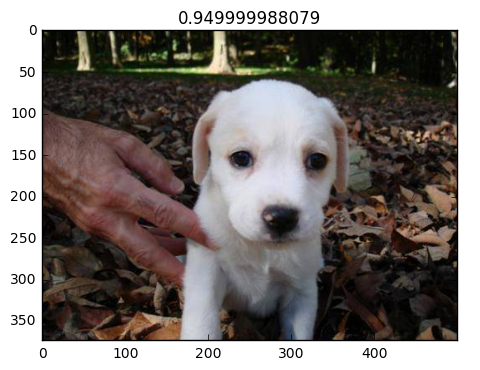

In [270]:
import matplotlib.image as mpimg
nrSamples = 5
randomSample = submission.sample(n=nrSamples)
for index, row in randomSample.iterrows():
    img=mpimg.imread(dataPath + "/test/unknown/" + row["id"] + ".jpg")
    imgplot = plt.imshow(img)
    plt.title(row["label"])
    plt.show()


In [285]:
%cd $notebookPath
fileName = "kaggle" + "/" + competitionName + "/submissionv2.csv"
submission.to_csv(fileName, index=False)
from IPython.display import FileLink
FileLink(fileName)

/home/ubuntu/nbs/fastAI


/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/submissionv2.csv

/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition


/home/ubuntu/nbs/fastAI/kaggle/dogs-vs-cats-redux-kernels-edition/submissionv2.csv